## Thesis construction site: Analysing pre-trained language models with topic models

*This file is used for local testing and experimenting on single functions without context*

**This file is not needed for reproducing the results of the thesis!**

In [1]:
# Library imports
import numpy as np
import os.path
import logging
import itertools
import re
import json
from gensim.models.ldamulticore import LdaMulticore
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
from matplotlib.patches import Rectangle
from nltk.tokenize import RegexpTokenizer
from pprint import pprint
from gensim.utils import SaveLoad
import pandas as pd
from gensim.corpora import Dictionary
from pathlib import Path
from tqdm.auto import tqdm
import gc
import torch
from transformers import set_seed
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer
from gensim.models import Phrases
from nltk.stem.wordnet import WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from wordcloud import WordCloud
from octis.dataset.dataset import Dataset

import generate_corpora, train_lda, score_lda


# Seed for reproducibility
set_seed(42)

# Tensorflow or Pytorch
framework = "pt"     # "tf" possible but not configured for that

# Use GPU or CPU
use_gpu = True
torch.set_num_threads(torch.get_num_threads()*2-2)
device = "cuda" if torch.cuda.is_available() and use_gpu else "cpu"

# Params
corpus_size = 1e6   # depending on the number of topics created with lda
data_path = "./data/"

gc.collect()
torch.cuda.empty_cache()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [ ]:
with open("./data/test/cv_score_reduced_docs.json", "r") as file:
    cv_red = json.load(file)
with open("./data/test/cv_score.json", "r") as file:
    cv_norm = json.load(file)
for key in cv_red.keys():
    print(abs(np.asarray(cv_norm[key]) - np.asarray(cv_red[key])))

In [11]:
dataset_object = Dataset(
        corpus=doc,
        vocabulary=list(dic.token2id.keys()),
        metadata=dict()
    )

In [ ]:
dataset_object.get_corpus()

In [ ]:
train_lda.train_neural_lda(doc, dic, 10, 42, "./data/test/", "")

In [ ]:
from gensim.matutils import kullback_leibler, jensen_shannon
def diff(main, other, distance="kullback_leibler", num_words=100, n_ann_terms=10, diagonal=False, annotation=True, normed=True):
    distances = {
        "kullback_leibler": kullback_leibler,
        "jensen_shannon": jensen_shannon
    }

    if distance not in distances:
        valid_keys = ", ".join("`{}`".format(x) for x in distances.keys())
        raise ValueError("Incorrect distance, valid only {}".format(valid_keys))

    if not isinstance(other, main.__class__):
        raise ValueError("The parameter `other` must be of type `{}`".format(main.__name__))

    distance_func = distances[distance]
    d1, d2 = main.get_topic_word_mat(), other.get_topic_word_mat()
    t1_size, t2_size = d1.shape[0], d2.shape[0]
    num_words = min(num_words, d1.shape[1])
    annotation_terms = None

    fst_topics = [{w for w in main.get_topics(k=num_words)[topic]} for topic in range(t1_size)]
    snd_topics = [{w for w in other.get_topics(k=num_words)[topic]} for topic in range(t2_size)]

    if diagonal:
        assert t1_size == t2_size, \
            "Both input models should have same no. of topics, " \
            "as the diagonal will only be valid in a square matrix"
        # initialize z and annotation array
        z = np.zeros(t1_size)
        if annotation:
            annotation_terms = np.zeros(t1_size, dtype=list)
    else:
        # initialize z and annotation matrix
        z = np.zeros((t1_size, t2_size))
        if annotation:
            annotation_terms = np.zeros((t1_size, t2_size), dtype=list)

    # iterate over each cell in the initialized z and annotation
    for topic in np.ndindex(z.shape):
        topic1 = topic[0]
        if diagonal:
            topic2 = topic1
        else:
            topic2 = topic[1]

        z[topic] = distance_func(d1[topic1], d2[topic2])
        if annotation:
            pos_tokens = fst_topics[topic1] & snd_topics[topic2]
            neg_tokens = fst_topics[topic1].symmetric_difference(snd_topics[topic2])

            pos_tokens = list(pos_tokens)[:min(len(pos_tokens), n_ann_terms)]
            neg_tokens = list(neg_tokens)[:min(len(neg_tokens), n_ann_terms)]

            annotation_terms[topic] = [pos_tokens, neg_tokens]

    if normed:
        if np.abs(np.max(z)) > 1e-8:
            z /= np.max(z)

    return z, annotation_terms

In [ ]:
mdiff, annotation = diff(model1.model, model2.model, distance="jensen_shannon", num_words=1000000)

## Experimenting individual functions on small data

### Removing Wikitext 103 Titles

In [ ]:
def removing_wikitext_titles(file_name):
    r"""
    Removing Titles and replacing them with one empty line between each text

    :param file_name: location of the file with titles
    """
    new_file_name = file_name+'_no_titles.txt'
    if not os.path.isfile(new_file_name):
        str0 = Path(file_name).read_text(encoding='utf-8')
        heading_pattern = '( \n [=\s].*[=\s] \n)'
        str1 = re.sub(heading_pattern, '\n\n', str0)
        str2 = re.sub('\n\n+[\n]', '\n\n', str1)
        with open(file=new_file_name, mode='x', encoding='utf-8') as file:
            file.write(str2)
    else:
        print("ERROR: File already exists. Must be deleted manually.")

train = './data/data_wikitext-103-raw/wiki.train.raw'
test = './data/data_wikitext-103-raw/wiki.test.raw'
valid = './data/data_wikitext-103-raw/wiki.valid.raw'
removing_wikitext_titles(train)
removing_wikitext_titles(test)
removing_wikitext_titles(valid)

### Training your own language model

`python run_clm.py --model_type gpt2 --tokenizer_name gpt2 --dataset_name wikitext --dataset_config_name wikitext-103-raw-v1 --output_dir data/test --do_eval --do_train --block_size 1024 --overwrite_output_dir`

or

`python run_clm.py --model_type gpt2 --tokenizer_name gpt2 --output_dir data/test --do_eval --do_train --block_size 1024 --overwrite_output_dir --train_file .\data\data_wikitext-103-raw\wiki.train.raw.txt --validation_file .\data\data_wikitext-103-raw\wiki.valid.raw.txt`

**For validation/perplexity score only:**
`python run_clm.py --model_type gpt2 --tokenizer_name gpt2 --output_dir data/test --do_eval --block_size 1024 --overwrite_output_dir --validation_file .\data\data_wikitext-103-raw\wiki.valid.raw.txt`

### Generating documents from selected pre-trained language models

In [ ]:
from transformers import XGLMForCausalLM, XGLMTokenizer

set_seed(42)
generate_corpora.create_corpus(
            tokenizer_name="facebook/xglm-564M",
            model_name="facebook/xglm-564M",
            max_document_length=100,
            device=device,
            corpus_size=1,
            tokenizer_model=XGLMTokenizer,
            lm_model=XGLMForCausalLM,
            #bos_token_id='eos_token_id',
            #pad_token_id='eos_token_id',
            save_path=f"data/test2.json",
            load_size=1
        )

In [ ]:
from transformers import TransfoXLTokenizer, TransfoXLLMHeadModel
import generate_corpora
from transformers import set_seed
import torch
import random
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)
generate_corpora.create_corpus(
            tokenizer_name="transfo-xl-wt103",
            model_name=f"./data/model-trafo_xl-wiki",
            max_document_length=3,
            device=device,
            corpus_size=3,
            tokenizer_model=TransfoXLTokenizer,
            lm_model=TransfoXLLMHeadModel,
            bos_token_id='eos_token_id',
            pad_token_id='eos_token_id',
            save_path=f"data/test01.json",
            load_size=1
        )
a, b, c, d = get_state(device)
set_seed(42)
set_state(a, b, c, d, device)
generate_corpora.create_corpus(
            tokenizer_name="transfo-xl-wt103",
            model_name=f"./data/model-trafo_xl-wiki",
            max_document_length=100,
            device=device,
            corpus_size=3,
            tokenizer_model=TransfoXLTokenizer,
            lm_model=TransfoXLLMHeadModel,
            bos_token_id='eos_token_id',
            pad_token_id='eos_token_id',
            save_path=f"data/test02.json",
            load_size=1
        )

In [ ]:
from transformers import TransfoXLTokenizer, TransfoXLLMHeadModel
import generate_corpora
from transformers import set_seed
import torch
import random
import numpy as np

set_seed(42)
generate_corpora.create_corpus(
            tokenizer_name="transfo-xl-wt103",
            model_name=f"./data/model-trafo_xl-wiki",
            max_document_length=100,
            device=device,
            corpus_size=6,
            tokenizer_model=TransfoXLTokenizer,
            lm_model=TransfoXLLMHeadModel,
            bos_token_id='eos_token_id',
            pad_token_id='eos_token_id',
            save_path=f"data/test2.json",
            load_size=2
        )

In [36]:
state = np.random.get_state()

In [ ]:
state

In [24]:
with open("./data/test_rng.json", "r") as file:
    state = json.load(file)

In [ ]:
(state[1][0], tuple(state[1][1]), None)

In [ ]:
generate_corpora.create_corpus(
    tokenizer_name="gpt2",  # "EleutherAI/gpt-neo-2.7B"
    model_name="gpt2",  # "EleutherAI/gpt-neo-2.7B"
    max_document_length=None,   # 2048
    device=device,
    corpus_size=1000,
    tokenizer_model=GPT2Tokenizer,
    lm_model=GPT2LMHeadModel,   # GPTNeoForCausalLM
    pad_token_id='eos_token_id',
    bos_token_id='eos_token_id',
    save_path="data/data_gpt2.json",
    load_size=5
)

### Training an LDA Model (Latent Dirichlet Allocation)

In [ ]:
docs1 = train_lda.load_wikitext()
docs2 = train_lda.load_arxiv()
dictionary_1, corpus_1, dictionary_2, corpus_2 = train_lda.tokenize_bow_dual(docs1, docs2, union=True)

In [ ]:
ldamodel_1 = train_lda.train_lda(dictionary_1, corpus_1)
ldamodel_2 = train_lda.train_lda(dictionary_2, corpus_2)

### Load pre-trained LDA Models

In [23]:
path1 = "lda-gpt2_nt-wiki_nt/wiki_nt"
path2 = "lda-gpt2_nt-wiki_nt/gpt2_nt"
topics = 10
mode = "union"   # "union", "intersection"

path_ldamodel_1 = f"data/{path1}/{mode}/{topics}/ldamodel_{topics}"
path_ldamodel_2 = f"data/{path2}/{mode}/{topics}/ldamodel_{topics}"
path_dictionary_1 = f"data/{path1}/{mode}/{topics}/dictionary_{topics}"
path_dictionary_2 = f"data/{path2}/{mode}/{topics}/dictionary_{topics}"
path_corpus_1 = f"data/{path1}/{mode}/{topics}/corpus_{topics}"
path_corpus_2 = f"data/{path2}/{mode}/{topics}/corpus_{topics}"

# Load pretrained model from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
dictionary_1 = SaveLoad.load(path_dictionary_1)
dictionary_2 = SaveLoad.load(path_dictionary_2)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

gamma_1, _ = ldamodel_1.inference(corpus_1)
doc_topic_dist_1 = gamma_1 / gamma_1.sum(axis=1)[:, None]

gamma_2, _ = ldamodel_2.inference(corpus_2)
doc_topic_dist_2 = gamma_2 / gamma_2.sum(axis=1)[:, None]

### Visualizing an LDA Model

In [ ]:
# pcoa, mmds, tsne
vis_data_wiki = gensimvis.prepare(ldamodel_1, corpus_1, dictionary_1, mds='tsne', sort_topics=True)
pyLDAvis.display(vis_data_wiki)

In [ ]:
vis_data_gpt = gensimvis.prepare(ldamodel_2, corpus_2, dictionary_2, mds='tsne', sort_topics=True)
pyLDAvis.display(vis_data_gpt)

### Comparing two LDA Models

In [33]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', vmin=0.0, vmax=1.0, origin='lower')
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(MaxNLocator(integer=True))
    plt.title(title)
    plt.colorbar(data)
    #plt.savefig(f"./data/test_{topics}.png", dpi=300)

distance = 'jensen_shannon' # 'kullback_leibler', 'hellinger', 'jaccard', 'jensen_shannon'
num_words = 1000000000

2022-03-31 12:46:39,648 : DEBUG : locator: <matplotlib.ticker.AutoLocator object at 0x0000028DFD1EBB80>


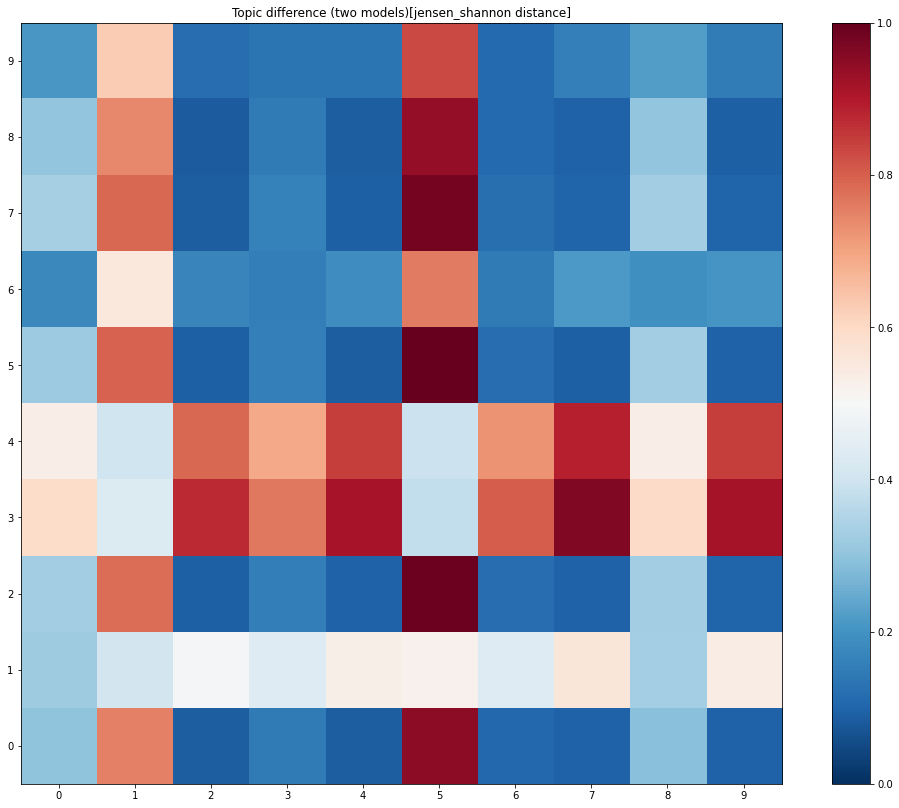

In [34]:
plot_difference_matplotlib(mdiff, title=f"Topic difference (two models)[{distance} distance]", annotation=annotation)

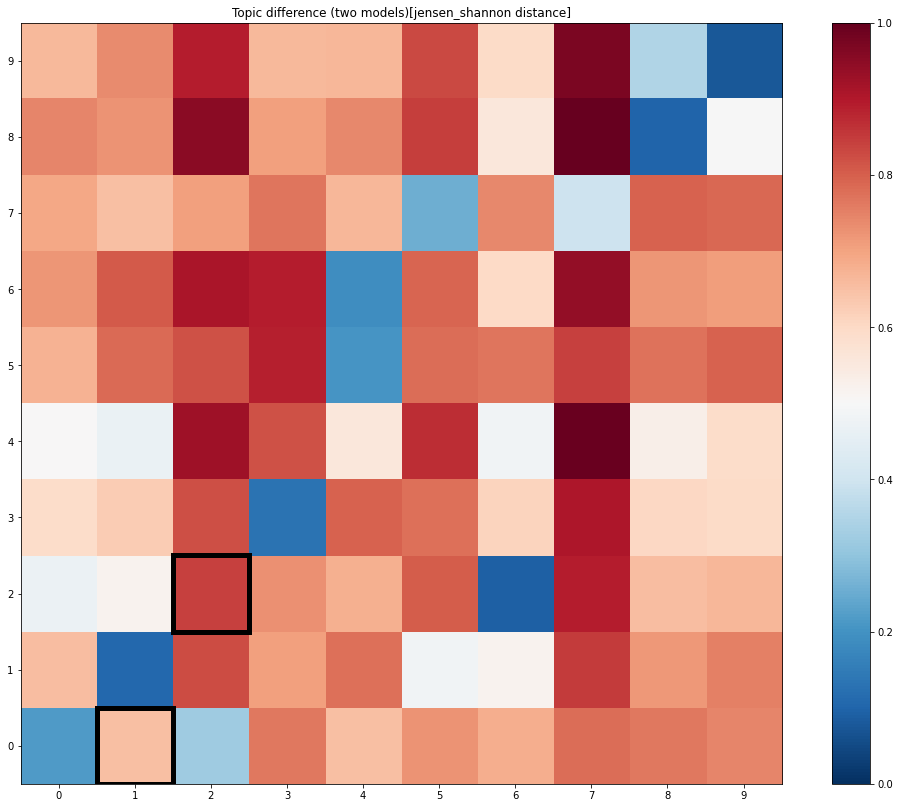

In [16]:
mdiff, annotation = ldamodel_2.diff(ldamodel_1, distance=distance, num_words=num_words)
plot_difference_matplotlib(mdiff, title=f"Topic difference (two models)[{distance} distance]", annotation=annotation)

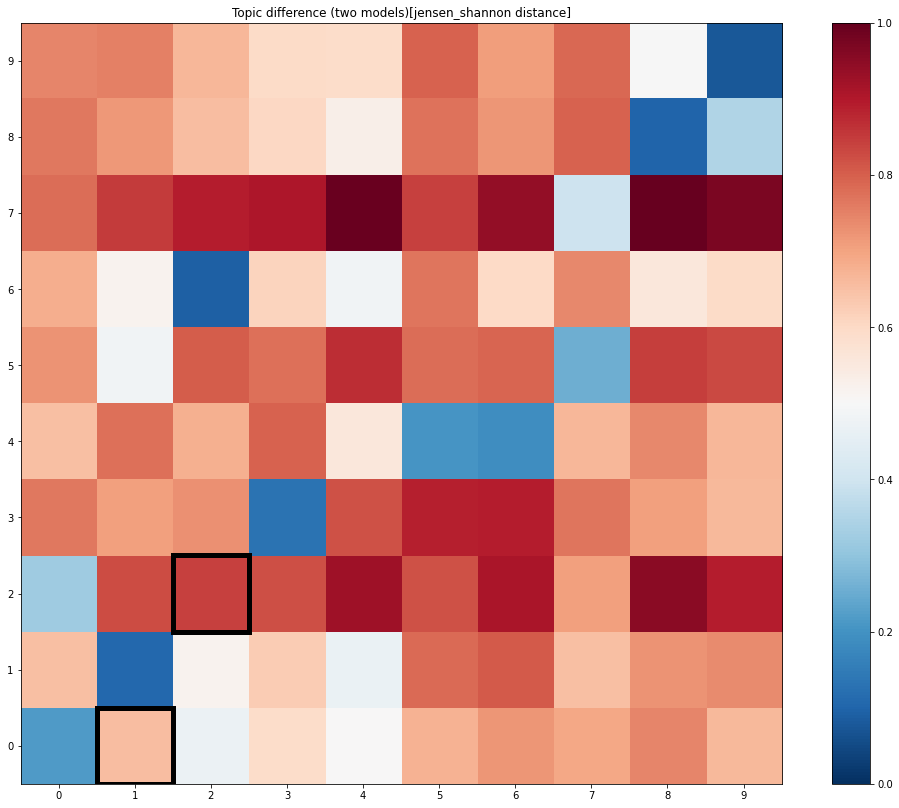

In [17]:
mdiff, annotation = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=num_words)
plot_difference_matplotlib(mdiff, title=f"Topic difference (two models)[{distance} distance]", annotation=annotation)

### Score function for evaluating how equal two LDA Models are

In [10]:
def score_by_topic_probability(ldamodel_1, ldamodel_2, corpus_1, corpus_2, distance='jensen_shannon'):
    mdiff1, annotation1 = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=1000000000)
    mdiff2, annotation2 = ldamodel_2.diff(ldamodel_1, distance=distance, num_words=1000000000)
    min1 = np.amin(mdiff1, axis=1)
    min2 = np.amin(mdiff2, axis=1)
    topic_corpus_prob_1 = np.zeros(ldamodel_1.num_topics)
    topic_corpus_prob_2 = np.zeros(ldamodel_2.num_topics)
    probas_1 = ldamodel_1.get_document_topics(list(itertools.chain.from_iterable(corpus_1)), minimum_probability=0.0)
    probas_2 = ldamodel_2.get_document_topics(list(itertools.chain.from_iterable(corpus_2)), minimum_probability=0.0)
    for key, val in probas_1:
        topic_corpus_prob_1[key] = val
    for key, val in probas_2:
        topic_corpus_prob_2[key] = val
    return (np.sum(topic_corpus_prob_1 * min1) + np.sum(topic_corpus_prob_2 * min2)) / 2


def score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2, distance='jensen_shannon'):
    mdiff1, annotation1 = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=1000000000)
    mdiff2, annotation2 = ldamodel_2.diff(ldamodel_1, distance=distance, num_words=1000000000)
    min1 = np.amin(mdiff1, axis=1)
    min2 = np.amin(mdiff2, axis=1)

    cnt1 = np.zeros(ldamodel_1.num_topics)
    for doc in corpus_1:
        topic_prob_list = ldamodel_1.get_document_topics(doc, minimum_probability=0.0)
        topic_prob_tupel = max(topic_prob_list, key=itemgetter(1))
        cnt1[topic_prob_tupel[0]] += 1
    cnt2 = np.zeros(ldamodel_1.num_topics)
    for doc in corpus_2:
        topic_prob_list = ldamodel_2.get_document_topics(doc, minimum_probability=0.0)
        topic_prob_tupel = max(topic_prob_list, key=itemgetter(1))
        cnt2[topic_prob_tupel[0]] += 1

    return (np.sum(cnt1 * min1) / np.sum(cnt1) + np.sum(cnt2 * min2) / np.sum(cnt2)) / 2

In [2]:
model_pair = ("lda-wiki_nt-gpt2_nt/wiki_nt", "lda-wiki_nt-gpt2_nt/gpt2_nt")
topic = 5
mode = "union"
path1 = model_pair[0]
path2 = model_pair[1]
path_ldamodel_1 = f"data/{path1}/{mode}/{topic}/ldamodel_{topic}"
path_ldamodel_2 = f"data/{path2}/{mode}/{topic}/ldamodel_{topic}"
path_dictionary_1 = f"data/{path1}/{mode}/{topic}/dictionary_{topic}"
path_dictionary_2 = f"data/{path2}/{mode}/{topic}/dictionary_{topic}"
path_corpus_1 = f"data/{path1}/{mode}/{topic}/corpus_{topic}"
path_corpus_2 = f"data/{path2}/{mode}/{topic}/corpus_{topic}"

# Load pretrained models from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
dictionary_1 = SaveLoad.load(path_dictionary_1)
dictionary_2 = SaveLoad.load(path_dictionary_2)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

distance = 'jensen_shannon'
words = 100000000

In [3]:
a = ldamodel_1.get_document_topics(list(itertools.chain.from_iterable(corpus_1)), minimum_probability=0.0)

In [4]:
b = ldamodel_2.get_document_topics(list(itertools.chain.from_iterable(corpus_2)), minimum_probability=0.0)

In [12]:
from operator import itemgetter
tup = max(b, key=itemgetter(1))[0]

In [ ]:
type(tup)

In [30]:
a

[(0, 0.023148753),
 (1, 0.0028030737),
 (2, 0.016371729),
 (3, 0.0014072682),
 (4, 0.0022580405),
 (5, 0.009407448),
 (6, 0.007316898),
 (7, 0.00894459),
 (8, 0.011694404),
 (9, 0.008548111),
 (10, 0.006001778),
 (11, 0.028335033),
 (12, 0.002321526),
 (13, 0.004526338),
 (14, 0.014262614),
 (15, 0.010423615),
 (16, 0.01470411),
 (17, 0.0023821525),
 (18, 0.0020809616),
 (19, 0.012897339),
 (20, 0.010726887),
 (21, 0.0061916686),
 (22, 0.0103839),
 (23, 0.007435687),
 (24, 0.0031629896),
 (25, 0.016836846),
 (26, 0.002798819),
 (27, 0.0020177981),
 (28, 0.011548738),
 (29, 0.0084394),
 (30, 0.011539556),
 (31, 0.0065206145),
 (32, 0.0028019636),
 (33, 0.009506046),
 (34, 0.009114019),
 (35, 0.00586084),
 (36, 0.0104628),
 (37, 0.0050772345),
 (38, 0.003920392),
 (39, 0.0066951495),
 (40, 0.016898306),
 (41, 0.020711036),
 (42, 0.008364165),
 (43, 0.026002608),
 (44, 0.005680909),
 (45, 0.00496998),
 (46, 0.009889519),
 (47, 0.006774921),
 (48, 0.0038970679),
 (49, 0.006484387),
 (50, 0

In [8]:
path_dictionary_1 = "data/lda-wiki_nt-gpt2_nt/gpt2_nt/intersection/2/dictionary_2"
path_dictionary_2 = "data/lda-wiki_nt-gpt2_nt/gpt2_nt/union/2/dictionary_2"
dictionary_1 = SaveLoad.load(path_dictionary_1)
dictionary_2 = SaveLoad.load(path_dictionary_2)

In [15]:
len(dictionary_1.keys())

36778

In [16]:
len(dictionary_2.keys())

67773

## Full Data Processing

### Creating a score-topics graph for all model types

In [4]:
def calc_score():
    topics = np.asarray([2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100])
    modes = ["intersection", "union"]
    model_pairs = [
        (
            "lda-wiki_nt-gpt2_nt/wiki_nt",
            "lda-wiki_nt-gpt2_nt/gpt2_nt"
        ),
        (
            "lda-gpt2_nt-gpt2_nt/gpt2_1_nt",
            "lda-gpt2_nt-gpt2_nt/gpt2_2_nt"
        ),
        (
            "lda-gpt2_nt-arxiv/gpt2_nt",
            "lda-gpt2_nt-arxiv/arxiv"
        ),
        (
            "lda-wiki_nt-arxiv/wiki_nt",
            "lda-wiki_nt-arxiv/arxiv"
        ),
        (
            "lda-gpt2-gpt2/gpt2_1",
            "lda-gpt2-gpt2/gpt2_2",
        )
    ]
    length = len(topics) * len(modes) * len(model_pairs)
    with tqdm(total=length) as pbar:
        for model_pair in model_pairs:
            for mode in modes:
                for idx, topic in enumerate(topics):
                    path1 = model_pair[0]
                    path2 = model_pair[1]
                    path_ldamodel_1 = f"data/{path1}/{mode}/{topic}/ldamodel_{topic}"
                    path_ldamodel_2 = f"data/{path2}/{mode}/{topic}/ldamodel_{topic}"
                    path_dictionary_1 = f"data/{path1}/{mode}/{topic}/dictionary_{topic}"
                    path_dictionary_2 = f"data/{path2}/{mode}/{topic}/dictionary_{topic}"
                    path_corpus_1 = f"data/{path1}/{mode}/{topic}/corpus_{topic}"
                    path_corpus_2 = f"data/{path2}/{mode}/{topic}/corpus_{topic}"

                    # Load pretrained models from disk.
                    with open(path_corpus_1, 'r') as file:
                        corpus_1 = json.load(file)
                    with open(path_corpus_2, 'r') as file:
                        corpus_2 = json.load(file)
                    dictionary_1 = SaveLoad.load(path_dictionary_1)
                    dictionary_2 = SaveLoad.load(path_dictionary_2)
                    ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
                    ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

                    distance = 'jensen_shannon'
                    words = 100000000
                    short_mode = "is" if mode == "intersection" else "un"
                    '''
                    # Compare models with score and save
                    diff_score = score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2)

                    score_topic_graph_file = "data/score_topic_graph_values.json"

                    if os.path.isfile(score_topic_graph_file):
                        with open(score_topic_graph_file, 'r') as file:
                            score_topic_graph_values = json.load(file)
                    else:
                        score_topic_graph_values = dict()


                    key = f"{path1.split('/')[0]}-{short_mode}"
                    if key not in score_topic_graph_values.keys():
                        score_topic_graph_values[key] = np.ones(topics.shape).tolist()

                    score_topic_graph_values[key][idx] = diff_score

                    with open(score_topic_graph_file, 'w') as file:
                        json.dump(score_topic_graph_values, file)
                    '''
                    # Calculate Difference Graph and save it
                    mdiff, annotation = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=1000000000)
                    fig, ax = plt.subplots(figsize=(18, 14))
                    data = ax.imshow(mdiff, cmap='RdBu_r', vmin=0.0, vmax=1.0, origin='lower')
                    for axis in [ax.xaxis, ax.yaxis]:
                        axis.set_major_locator(MaxNLocator(integer=True))
                    plt.title(
                        f"Topic difference ({path1.split('/')[1]} - {path2.split('/')[1]} - {mode})[{distance} distance] for {topic} topics")
                    plt.colorbar(data)
                    plt.savefig(f"./data/{path1.split('/')[0]}/diff_{short_mode}_{topic}.png", dpi=300)
                    plt.close('all')
                    pbar.update(1)

In [5]:
calc_score()

  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
score_topic_graph_file = "data/score_topic_graph_values.json"

if os.path.isfile(score_topic_graph_file):
    with open(score_topic_graph_file, 'r') as file:
        score_topic_graph_values = json.load(file)

names = score_topic_graph_values.values()
values = score_topic_graph_values.values()
plt.clf()
fig, axes = plt.subplots()
for idx, value in enumerate(values):
    axes.plot(topics, value, label=names[idx])
axes.legend()
axes.set_title(f"Score-Topic Graph for LDA Models")
axes.set_xscale('log')
axes.set_xlabel('Number of Topics')
axes.set_ylabel('Score (lower is better)')
axes.set_xticks(topics)
axes.get_xaxis().set_major_formatter(ScalarFormatter())
plt.savefig(f"./data/score_topic_graph.png", dpi=300)
plt.close('all')

In [3]:
switch = True
if switch:
    score_file_path = "data/score_by_top_topic.json"
    title = "'Score by Top Topic'-Topic Graph for LDA Models"
    y_label = "Score by Top Topic (lower is better)"
else:
    score_file_path = "data/score_by_topic_probability_values.json"
    title = "'Score by Topic Probability'-Topic Graph for LDA Models"
    y_label = "Score by Topic Probability (lower is better)"
if os.path.isfile(score_file_path):
    with open(score_file_path, 'r') as file:
        score_values = json.load(file)

In [7]:
list(score_values.keys())

['lda-wiki_nt-gpt2_nt-is',
 'lda-wiki_nt-gpt2_nt-un',
 'lda-gpt2_nt-gpt2_nt-is',
 'lda-gpt2_nt-gpt2_nt-un',
 'lda-gpt2_nt-arxiv-is',
 'lda-gpt2_nt-arxiv-un',
 'lda-wiki_nt-arxiv-is',
 'lda-wiki_nt-arxiv-un',
 'lda-gpt2-gpt2-is',
 'lda-gpt2-gpt2-un']

### Create a Wordcloud of every topic in an LDA Model

In [ ]:
x = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])

for model in tqdm([0, 1, 2], desc='Model', leave=True):
    for topics in tqdm(x, desc='Topic', leave=False):
        if model == 0:
            path1 = "lda-wiki_no_titles-gpt2_no_titles/wiki_nt"
            path2 = "lda-wiki_no_titles-gpt2_no_titles/gpt2_nt"
        elif model == 1:
            path1 = "lda-gpt2_no_titles-gpt2_no_titles/gpt2_1_nt"
            path2 = "lda-gpt2_no_titles-gpt2_no_titles/gpt2_2_nt"
        else:
            path1 = "lda-gpt2-gpt2/gpt2_1"
            path2 = "lda-gpt2-gpt2/gpt2_2"

        path_ldamodel_1 = f"data/{path1}/{topics}/ldamodel_{topics}"
        path_ldamodel_2 = f"data/{path2}/{topics}/ldamodel_{topics}"
        path_dictionary_1 = f"data/{path1}/{topics}/dictionary_{topics}"
        path_dictionary_2 = f"data/{path2}/{topics}/dictionary_{topics}"
        path_corpus_1 = f"data/{path1}/{topics}/corpus_{topics}"
        path_corpus_2 = f"data/{path2}/{topics}/corpus_{topics}"

        # Load a potentially pretrained model from disk.
        with open(path_corpus_1, 'r') as file:
            corpus_1 = json.load(file)
        with open(path_corpus_2, 'r') as file:
            corpus_2 = json.load(file)
        dictionary_1 = SaveLoad.load(path_dictionary_1)
        dictionary_2 = SaveLoad.load(path_dictionary_2)
        ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
        ldamodel_2 = LdaMulticore.load(path_ldamodel_2)
        for topic in range(ldamodel_1.num_topics):
            plt.clf()
            plt.figure()
            plt.imshow(WordCloud().fit_words(dict(ldamodel_1.show_topic(topic, 200))))
            plt.axis("off")
            plt.title(f"{path1.split('/')[1]} LDA Model with {topics} Topics - Topic {topic}")
            plt.savefig(f"./data/{path1.split('/')[0]}/wordcloud_{path1.split('/')[1]}_{topics}_{topic}.png", dpi=600)

        for topic in range(ldamodel_2.num_topics):
            plt.clf()
            plt.figure()
            plt.imshow(WordCloud().fit_words(dict(ldamodel_1.show_topic(topic, 200))))
            plt.axis("off")
            plt.title(f"{path2.split('/')[1]} LDA Model with {topics} Topics - Topic {topic}")
            plt.savefig(f"./data/{path2.split('/')[0]}/wordcloud_{path2.split('/')[1]}_{topics}_{topic}.png", dpi=600)

## DEAD ATTEMPTS (EVENTUALLY TO DELETE)

### Create Average Topic Coherence Graphs for all LDAs

In [ ]:
for pathname in ["data/lda-wiki_no_titles-gpt2_no_titles", "data/lda-gpt2_no_titles-gpt2_no_titles", "data/lda-gpt2-gpt2"]:
    path = pathname
    x = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100])
    y_1 = np.zeros(12)
    y_2 = np.zeros(12)
    label1 = None
    label2 = None

    for filename in os.listdir(path + "/execution_dump"):
        with open(os.path.join(path + "/execution_dump", filename), 'r', encoding='utf-8') as f:
            text = f.read()
            rex = "Average topic coherence: "
            idx = text.find(rex)
            num = float(text[idx+len(rex):idx+len(rex)+7])
            filenum = filename.split("_")[-1][:-4]
            if 'wiki_' in filename or 'gpt2_1_' in filename or 'gpt2_nt_1_' in filename:
                y_1[np.where(x == int(filenum))] = num
                label1 = '_'.join(filename.split("_")[:-1])
                print("ONE")
            else:
                y_2[np.where(x == int(filenum))] = num
                label2 = '_'.join(filename.split("_")[:-1])
                print("TWO")
            f.close()

    plt.clf()
    fig, axes = plt.subplots()
    line1, = axes.plot(x, y_1, label=label1)
    line2, = axes.plot(x, y_2, label=label2)
    axes.legend(handles=[line1, line2])
    axes.set_title(f"Average Topic Coherence Graph")
    axes.set_xscale('log')
    axes.set_xlabel('Number of Topics')
    axes.set_ylabel('Umass Score')
    axes.set_xticks(x)
    axes.get_xaxis().set_major_formatter(ScalarFormatter())
    plt.savefig(path+f"/umass_plot_{label1}-{label2}.png", dpi=300)

In [11]:
path1 = "lda-wiki_nt-gpt2_nt/gpt2_nt"
path2 = "lda-wiki_nt-gpt2_nt/wiki_nt"
i = 1
j = 1
mode = 'intersection'
topic = 5
path_ldamodel_1 = f"./data/{path1}/{i}/{mode}/{topic}/ldamodel_{topic}"
path_ldamodel_2 = f"./data/{path2}/{j}/{mode}/{topic}/ldamodel_{topic}"
path_corpus_1 = f"./data/{path1}/{i}/{mode}/{topic}/corpus_{topic}"
path_corpus_2 = f"./data/{path2}/{j}/{mode}/{topic}/corpus_{topic}"

# Load pretrained models from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

# Compare models with scores_by_topic_probability and save
diff_score = score_by_topic_probability(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)
# Compare models with score_by_top_topic and save
diff_score = score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)

0.19000747182747096
0.1996428388861695


In [12]:
path1 = "lda-wiki_nt-gpt2_nt/gpt2_nt"
path2 = "lda-wiki_nt-gpt2_nt/wiki_nt"
i = 1
j = 2
mode = 'intersection'
topic = 5
path_ldamodel_1 = f"./data/{path1}/{i}/{mode}/{topic}/ldamodel_{topic}"
path_ldamodel_2 = f"./data/{path2}/{j}/{mode}/{topic}/ldamodel_{topic}"
path_corpus_1 = f"./data/{path1}/{i}/{mode}/{topic}/corpus_{topic}"
path_corpus_2 = f"./data/{path2}/{j}/{mode}/{topic}/corpus_{topic}"

# Load pretrained models from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

# Compare models with scores_by_topic_probability and save
diff_score = score_by_topic_probability(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)
# Compare models with score_by_top_topic and save
diff_score = score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)

0.19000747182747096
0.1996428388861695
